# Example usage of the TaylorAnalysis

This is an example for the usage of the TaylorAnalysis tool. 
It is designed to work on a very essential level in order to leave maximal flexibility to the user. 

Therefore some usecases and methods are shown how one may apply TaylorAnalysis.

In [1]:
import torch
import matplotlib.pyplot as plt
import itertools

from torch import nn
from helpers import gen_data, Mlp, plot_data, get_feature_combis
from tayloranalysis.model_extension import extend_model

### Setup Data

Create a two dimensional dataset with three classes which we want du discriminate against each other.

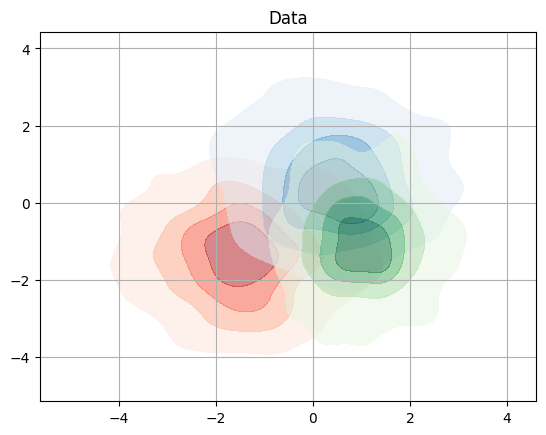

In [2]:
names = ["x1", "x2"]
x_train, y_train = gen_data(400)
x_test, y_test = gen_data(400)
plot_data(x_train, y_train)  

Split in train and test dataset and one-hot-encode the target labels for the training.

In [3]:
x_test, y_test, x_train, y_train = map(
    lambda x: torch.tensor(x).float(),
    (x_test, y_test, x_train, y_train),
)

# one hot encode y train
y_train = nn.functional.one_hot(y_train.to(torch.int64), 3).float()

### Setup Model and TaylorAnalyis tool

Now we will have a look at two ways on how to add the TaylorAnalysis functionality to a `torch` model.

First step is to define a reduce function in order to summarize the taylorcoefficients computed based on the points in the dataset.
The default is set to the identity function, i.e. no reduction is applied.
We will demonstrate this with a simple mean function.

Note: The reduce function also specifies the datatype which is written into the output dict!

In [4]:
def reduce(x: torch.Tensor):
    return torch.mean(x).cpu().detach().numpy()

Now extend an exemplary `Mlp` with the TaylorAnalysis functionality. Here we can either use the `Mlp` class as an input for the `extend_model` function...

In [5]:
WrappedMlp = extend_model(Mlp)
model = WrappedMlp(input_neurons=2, hidden_neurons=10, output_neurons=3, hiddenlayers=2)

... or an already initialized instance of `Mlp` which can be extendet by the Tayloranalysis functionality.

In [6]:
#model = Mlp(input_neurons=2, hidden_neurons=10, output_neurons=3, hiddenlayers=2)
#model = extend_model(model)

Now setup training parameters and move everything to cuda if available.

In [7]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
x_train = x_train.to(device)
y_train = y_train.to(device)
model.to(device)

Mlp(
  (mlplayers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1-3): 3 x Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

Determine the taylorcoefficients to compute. 
These must be a list of tuples!
For more numerious combinations you should use itertools, as exemplary shown!

In [8]:
combinations = [(0,), (1,)]  # 1st order taylor coefficients
combinations += [
    i for i in itertools.permutations([0, 1], 2)
]  # 2nd order taylor coefficients
combinations += [(0, 1, 1)]  # exemplary 3rd order taylor coefficient
combinations

[(0,), (1,), (0, 1), (1, 0), (0, 1, 1)]

This means we will compute:
- First order TCs of feature nr. 0 and feature nr. 1
- Second order TCs of feature combinations: nr. 0 and 1, as well as nr. 1 and 0
- Third order TC of feature combinations: nr. 0, 1, 1

### Training

Now start the training and write out taylorcoefficients after each epoch.

Have a look at the advanced arguments you can pass to the `get_tcs` function:

```
Function to handle multiple indices and return the taylorcoefficients as a dictionary: to be used by the user.

Args:
    x_key (str): Key to input tensor in forward_kwargs. Based on this tensor the taylorcoefficients are computed.
    forward_kwargs (Union[None, Dict[str, Any]], optional): Dictionary with additional forward arguments
    index_list (List[Tuple[int, ...]]): List of indices for which the taylorcoefficients should be computed.
    node (Int, optional): Node selection for evaluation. Defaults to None.
    eval_max_node_only (Bool, optional): If True, only the node with the highest value is selected. Defaults to True.
    reduce_func (Callable, optional): Function to reduce the taylorcoefficients. Defaults to identity.
    features_axis (int, optional): Dimension containing features in tensor forward_kwargs[x_key]. Defaults to -1.
Raises:
    ValueError: index_list must be a List of tuples!

Returns:
    Dict: Dictionary with taylorcoefficients. Values are set by the user within the reduce function. Keys are the indices (tuple).
```










In [9]:
tcs_training = []
x_train.requires_grad = True
for epoch in range(250):
    optim.zero_grad()
    pred = model(x_train)
    loss = crit(pred, y_train)
    loss.backward()
    optim.step()

    if epoch % 10 == 0:
        print("Epoch {}: Loss: {:.3f}".format(epoch + 1, loss))

    tc_dict = model.get_tc(
        "x",
        forward_kwargs={"x": x_test.to(device)},
        index_list=combinations, 
        reduce_func=reduce)
    # here we directly unpack the dictionary values into a list
    tcs_training.append(list(tc_dict.values()))

Epoch 1: Loss: 1.102
Epoch 11: Loss: 1.097
Epoch 21: Loss: 1.091
Epoch 31: Loss: 1.083
Epoch 41: Loss: 1.071
Epoch 51: Loss: 1.052
Epoch 61: Loss: 1.026
Epoch 71: Loss: 0.995
Epoch 81: Loss: 0.964
Epoch 91: Loss: 0.937
Epoch 101: Loss: 0.917
Epoch 111: Loss: 0.901
Epoch 121: Loss: 0.890
Epoch 131: Loss: 0.881
Epoch 141: Loss: 0.874
Epoch 151: Loss: 0.869
Epoch 161: Loss: 0.865
Epoch 171: Loss: 0.862
Epoch 181: Loss: 0.859
Epoch 191: Loss: 0.857
Epoch 201: Loss: 0.855
Epoch 211: Loss: 0.854
Epoch 221: Loss: 0.852
Epoch 231: Loss: 0.851
Epoch 241: Loss: 0.850


### Evaluation

Get the combinations with feature names instead of feature numbers for plotting. Have a look at the `get_feature_combis` function!

In [10]:
labels = get_feature_combis(names, combinations)
labels = [",".join(label) for label in labels]
labels

['x1', 'x2', 'x1,x2', 'x2,x1', 'x1,x2,x2']

Have a look at the development of the taylorcoefficients during the training!

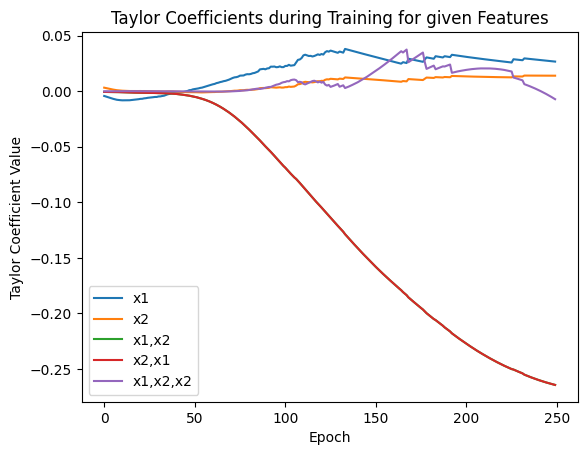

In [11]:
plt.title("Taylor Coefficients during Training for given Features")
plt.plot(tcs_training, label=labels)
plt.xlabel("Epoch")
plt.ylabel("Taylor Coefficient Value")
plt.legend()
plt.show()

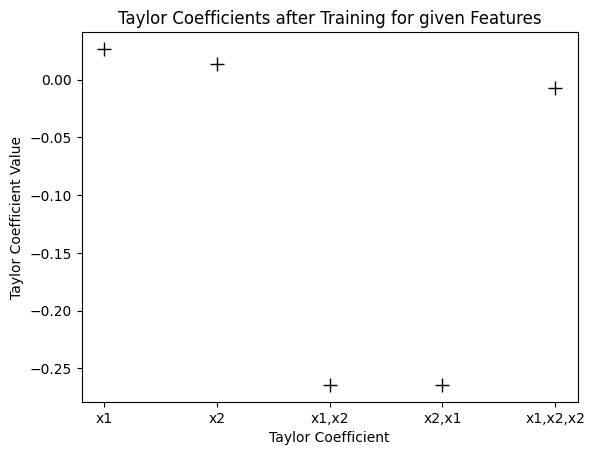

In [13]:
# get a set of target taylor coefficients after training
model.cpu()
tc_dict = model.get_tc(
    "x",
    forward_kwargs={"x": x_test},
    index_list=combinations,
    reduce_func=reduce)

# plot tcs after training
plt.title("Taylor Coefficients after Training for given Features")
plt.plot(labels, list(tc_dict.values()), "+", color="black", markersize=10)
plt.xlabel("Taylor Coefficient")
plt.ylabel("Taylor Coefficient Value")
plt.show()